# Chihuahua VS Muffins 
### (avec du transfer learning (mais en fait pas vraiment))

In [1]:
import os
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Gpu checks

Pour cette partie nous avons du faire tourner le modèle sur un GPU, ce qui à été éprouvant à faire fonctionner à cause des problèmes de versions de numpy car tout le monde se met d'accord pour compiler ses paquets en en utilisant des différentes.

In [3]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())  # Number of GPUs detected
if torch.cuda.is_available():
    print(torch.cuda.current_device())  # Current CUDA device index
    print(torch.cuda.get_device_name(0))  # Name of the GPU (if available)

False
0


## Importe les données depuis l'API Kaggle et les sauvegardes en cache

Même bout de code que pour l'autre notebook avec un petit check en plus pour CUDA.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = '../dataset'

if not os.path.exists(dataset_path) or not os.listdir(dataset_path):
    print("Dataset not found. Downloading now...")
    
    %pip install --quiet kaggle
    
    os.makedirs(dataset_path, exist_ok=True)
    
    !kaggle datasets download -d samuelcortinhas/muffin-vs-chihuahua-image-classification -p {dataset_path}
    
    import zipfile
    with zipfile.ZipFile(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'), 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(os.path.join(dataset_path, 'muffin-vs-chihuahua-image-classification.zip'))
    
    print("Dataset downloaded and extracted successfully.")
else:
    print("Dataset already exists. Using cached version.")


Dataset already exists. Using cached version.


Idem ici, nous chargeons les mêmes données.

In [4]:
# Chemins des répertoires train et test
train_dir = '../dataset/train'
test_dir = '../dataset/test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),                          # Resize les images à 224x224 pixels
    transforms.ToTensor(),                                  # Convertir l'image en tenseur
])

# Charger le dataset d'entraînement complet
train_data = datasets.ImageFolder(root=train_dir, transform=transform)

# Définir les proportions pour l'entraînement et la validation
train_size = int(0.8 * len(train_data))  # 80% pour l'entraînement
valid_size = len(train_data) - train_size  # 20% pour la validation

# Diviser le dataset d'entraînement en entraînement et validation
train_data, valid_data = random_split(train_data, [train_size, valid_size])

# Charger le dataset de test
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Définir la taille des batches
batch_size = 32

# Créer les DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Vérification des tailles
print(f"Taille du train_loader: {len(train_loader.dataset)} images")
print(f"Taille du valid_loader: {len(valid_loader.dataset)} images")
print(f"Taille du test_loader: {len(test_loader.dataset)} images")

print(f"Using device: {device}")

Taille du train_loader: 3786 images
Taille du valid_loader: 947 images
Taille du test_loader: 1184 images
Using device: cuda


## Chargement du modèle
Ici nous chargeons le modèle préentrainé resnet18. Qui est un réseau de neurone convolutifs profond de 18 couches qui à appris sur une variété d'images à en détecter le contenu.<br>
On modifies la couche de sortie pour avoir une couche linéaire avec deux sorties pour prédire chihuahua ou muffin.<br>
On porte ensuite le modèle sur le GPU et on défini la fonction de perte (crossentropy) et l'optimizer (Adam)

In [7]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

## Entraînement et validation
N'ayant pas besoin de relancer l'entrainement plusieurs fois nous ne l'avons pas mis dans une fonction. <br>
Nous entrainons de la même manière que nous l'avons fait pour notre modèle au détail prêt que nous portons les labels et inputs vers le GPU pour accélérer les calculs.

<br>
L'entrainement à seulement pris 10 minutes (RTX3060) alors qu'il aurait pris le quadruple sur mon vieux CPU.

In [8]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print training and validation results for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "f"Training Loss: {running_loss/len(train_loader):.4f}, "f"Validation Loss: {val_loss/len(valid_loader):.4f}, "f"Validation Accuracy: {100 * correct / total:.2f}%")

Epoch 1/10, Training Loss: 0.1600, Validation Loss: 0.0471, Validation Accuracy: 99.26%
Epoch 2/10, Training Loss: 0.0629, Validation Loss: 0.0343, Validation Accuracy: 99.26%
Epoch 3/10, Training Loss: 0.0533, Validation Loss: 0.0331, Validation Accuracy: 98.94%
Epoch 4/10, Training Loss: 0.0392, Validation Loss: 0.0267, Validation Accuracy: 99.37%
Epoch 5/10, Training Loss: 0.0334, Validation Loss: 0.0281, Validation Accuracy: 99.58%
Epoch 6/10, Training Loss: 0.0363, Validation Loss: 0.0230, Validation Accuracy: 99.47%
Epoch 7/10, Training Loss: 0.0335, Validation Loss: 0.0232, Validation Accuracy: 99.37%
Epoch 8/10, Training Loss: 0.0296, Validation Loss: 0.0225, Validation Accuracy: 99.37%
Epoch 9/10, Training Loss: 0.0334, Validation Loss: 0.0224, Validation Accuracy: 99.47%
Epoch 10/10, Training Loss: 0.0292, Validation Loss: 0.0319, Validation Accuracy: 98.94%


## Évaluation du modèle
Ici, de la même manière que nous l'avions fait pour la validation nous passons chaque images du set de test pour vérifier l'accuracy du modèle.<br>
La différence est encore une fois que nous portons les labels vers le GPU. On a aussi décidé de plot la matrice de confusion ainsi que les images n'ayant pas bien été prédites

Test Accuracy: 98.65%


<Figure size 800x600 with 0 Axes>

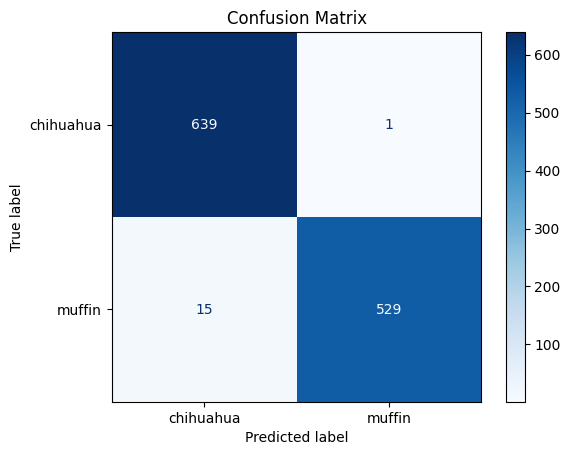

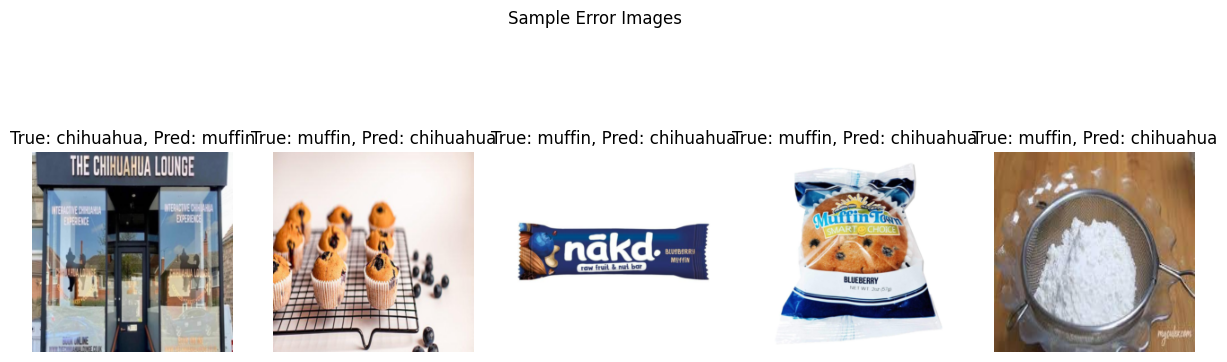

In [12]:
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_predictions = []
error_images = []
error_labels = []
error_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                error_images.append(inputs[i].cpu())
                error_labels.append(labels[i].cpu().item())
                error_predictions.append(predicted[i].cpu().item())

print(f"Test Accuracy: {100 * test_correct / test_total:.2f}%")

cm = confusion_matrix(all_labels, all_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.classes)

plt.figure(figsize=(8, 6))
display.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

if error_images:
    fig, axes = plt.subplots(1, min(5, len(error_images)), figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(error_images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        ax.set_title(f'True: {test_data.classes[error_labels[i]]}, Pred: {test_data.classes[error_predictions[i]]}')
        ax.axis('off')
    plt.show()

## Conclusion
Avec une si grande accuracy, nous n'avons pas eu besoin de trop toucher au paramétrage du modèle. De plus, on a pu se rendre compte que certaines images du dataset, ne sont ni des muffins, ni des chihuahua. Ce qui pourrait expliquer une partie de notre 1% d'accuracy manquant. <br>
Nous aurions pu tester d'autres modèles et les mettres en comparaison comme YOLO ou bien Inception. Malheureusement, le temps nous prends de court et nous nous arrêtons là. <br>
Pour conclure, nous avons bien aimé travailler sur ce dataset rigolo et somme fier de notre petit CNN à 87% d'accuracy. 